In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import datetime
import os
from pathlib import Path
from multiprocessing import Pool
import time
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

_ = load_dotenv(".envrc")
from backtest.utilities.utils import load_credentials
_ = load_credentials(os.getcwd() + "/real_credentials.json", into_env=True)

from backtest.utilities.utils import OPTION_METADATA_PATH, get_ms_from_datetime, read_universe_list
from Data.get_data import get_option_ticker_from_underlying

DATA_DIR = Path(os.environ["DATA_DIR"])

def read_df(fp):
    df = pd.read_csv(fp).sort_values("timestamp")
    df["dt"] = pd.to_datetime(df["timestamp"], unit="ms")
    return df

In [3]:
SPY_ohlc_day = read_df(DATA_DIR / "day/equity/SPY.csv")
SPY_ohlc_hour = read_df(DATA_DIR / "60minute/equity/SPY.csv")
SPY_ohlc_15min =read_df(DATA_DIR / "15minute/equity/SPY.csv")

In [4]:
display(SPY_ohlc_hour.tail())
display(SPY_ohlc_15min.tail())
display(SPY_ohlc_day.tail())

,timestamp,open,high,low,close,volume,vwap,num_trades,dt
2904,1695409200000,431.05,433.2100,429.99,430.38,26696139.0,431.1533,170511.0,2023-09-22 19:00:00
2905,1695412800000,430.38,433.6078,430.35,430.43,16125426.0,430.4713,6947.0,2023-09-22 20:00:00
2906,1695416400000,430.41,431.1800,430.41,430.85,229176.0,430.8159,1836.0,2023-09-22 21:00:00
2907,1695420000000,430.89,430.9000,430.66,430.70,30592.0,430.7870,255.0,2023-09-22 22:00:00
2908,1695423600000,430.66,430.8000,430.40,430.60,50695.0,430.5204,677.0,2023-09-22 23:00:00


,timestamp,open,high,low,close,volume,vwap,num_trades,dt
120802,1695422700000,430.70,430.70,430.70,430.70,4985.0,430.6985,28.0,2023-09-22 22:45:00
120803,1695423600000,430.66,430.68,430.42,430.50,19052.0,430.4877,229.0,2023-09-22 23:00:00
120804,1695424500000,430.45,430.50,430.40,430.50,15864.0,430.4241,155.0,2023-09-22 23:15:00
120805,1695425400000,430.49,430.75,430.42,430.75,5332.0,430.5353,74.0,2023-09-22 23:30:00
120806,1695426300000,430.55,430.80,430.50,430.60,10447.0,430.7186,219.0,2023-09-22 23:45:00


,timestamp,open,high,low,close,volume,vwap,num_trades,dt
1164,1691467200000,448.08,450.6952,445.2705,448.75,71319824.0,447.5390,527037.0,2023-08-08 04:00:00
1165,1691553600000,449.03,449.1999,444.9600,445.75,78789575.0,446.9664,559466.0,2023-08-09 04:00:00
1166,1691640000000,448.19,451.7000,444.7000,445.91,93005495.0,447.5472,680008.0,2023-08-10 04:00:00
1167,1691726400000,443.97,446.7007,443.3450,445.65,68636902.0,445.2738,502512.0,2023-08-11 04:00:00
1168,1691985600000,444.70,448.1100,444.3800,448.11,47825941.0,446.7275,404514.0,2023-08-14 04:00:00


In [5]:
SPY_ohlc_hour.tail(25)

,timestamp,open,high,low,close,volume,vwap,num_trades,dt
2884,1695308400000,434.1200,434.5700,433.650,433.9200,8182872.0,434.0930,73825.0,2023-09-21 15:00:00
2885,1695312000000,433.9200,434.1700,433.430,433.5770,7672708.0,433.9188,62375.0,2023-09-21 16:00:00
2886,1695315600000,433.5800,434.9000,433.490,434.4200,7256943.0,434.5932,60515.0,2023-09-21 17:00:00
2887,1695319200000,434.4300,434.4900,433.070,433.0800,10405522.0,433.9968,73530.0,2023-09-21 18:00:00
2888,1695322800000,433.0800,433.3900,431.230,431.4100,32366100.0,433.0085,186205.0,2023-09-21 19:00:00
2889,1695326400000,431.4300,434.2004,430.810,431.0100,8779462.0,431.5433,8438.0,2023-09-21 20:00:00
2890,1695330000000,430.9600,431.0900,430.880,431.0900,269166.0,431.2135,1540.0,2023-09-21 21:00:00
2891,1695333600000,431.0900,431.5800,431.090,431.4400,175485.0,431.3486,1267.0,2023-09-21 22:00:00
2892,1695337200000,431.4300,431.4800,431.050,431.1200,58484.0,431.2626,638.0,2023-09-21 23:00:00
2893,1695369600000,432.4600,432.4600,431.580,432.1000,35565.0,431.9195,403.0,2023-09-22 08:00:00


In [9]:
data_from = SPY_ohlc_hour.timestamp.min()
data_to = SPY_ohlc_hour.timestamp.max()
ticker_expiry_map = get_option_ticker_from_underlying(
    ["SPY"], 
    datetime.datetime.fromtimestamp(data_from / 1000), 
    datetime.datetime.fromtimestamp(data_to / 1000)
)
expiries = set(get_ms_from_datetime(v) for v in ticker_expiry_map.values())

In [11]:
SPY_ohlc_hour.dt.min(), SPY_ohlc_hour.dt.max(), datetime.datetime.fromtimestamp(data_from / 1000), datetime.datetime.fromtimestamp(data_to / 1000)

(Timestamp('2023-01-03 09:00:00'),
 Timestamp('2023-09-22 23:00:00'),
 datetime.datetime(2023, 1, 3, 17, 0),
 datetime.datetime(2023, 9, 23, 7, 0))

In [19]:
merged_df = pd.merge_asof(
    SPY_ohlc_hour.sort_values(by='timestamp'),
    pd.Series(sorted(expiries), name='expiry_ts').sort_values(),
    left_on='timestamp', right_on='expiry_ts',
    direction='forward'
) 
merged_df.dropna(inplace=True)
merged_df.expiry_ts = merged_df.expiry_ts.astype('int64')
merged_df["expiry_dt"] = pd.to_datetime(merged_df["expiry_ts"], unit="ms")
merged_df.tail(10)

,timestamp,open,high,low,close,volume,vwap,num_trades,dt,expiry_ts,expiry_dt
2659,1693490400000,452.430,452.8300,451.8100,452.340,7256071.0,452.3721,68051.0,2023-08-31 14:00:00,1693526400000,2023-09-01
2660,1693494000000,452.350,452.3700,451.4500,451.900,5236830.0,451.9238,47648.0,2023-08-31 15:00:00,1693526400000,2023-09-01
2661,1693497600000,451.910,452.2500,450.3600,450.965,6290012.0,451.2099,53385.0,2023-08-31 16:00:00,1693526400000,2023-09-01
2662,1693501200000,450.970,451.8700,450.7700,451.460,5466296.0,451.4230,43694.0,2023-08-31 17:00:00,1693526400000,2023-09-01
2663,1693504800000,451.470,452.1900,450.7801,450.880,7112570.0,451.4854,56898.0,2023-08-31 18:00:00,1693526400000,2023-09-01
2664,1693508400000,450.865,451.6800,450.1600,450.280,19232747.0,451.0129,113922.0,2023-08-31 19:00:00,1693526400000,2023-09-01
2665,1693512000000,450.280,451.9451,450.2400,450.560,7775206.0,450.4369,6514.0,2023-08-31 20:00:00,1693526400000,2023-09-01
2666,1693515600000,450.520,450.6500,450.4600,450.500,64118.0,450.5199,547.0,2023-08-31 21:00:00,1693526400000,2023-09-01
2667,1693519200000,450.500,450.5900,450.3300,450.440,56281.0,450.4253,494.0,2023-08-31 22:00:00,1693526400000,2023-09-01
2668,1693522800000,450.520,450.7000,450.4900,450.670,26250.0,450.6299,310.0,2023-08-31 23:00:00,1693526400000,2023-09-01


In [20]:
merged_df.shape

(2668, 11)

In [24]:
last_expiry = datetime.datetime(2023, 8, 1, 4)
merged_df.query("expiry_dt <= @last_expiry").tail()

,timestamp,open,high,low,close,volume,vwap,num_trades,dt,expiry_ts,expiry_dt
2296,1690830000000,457.059,457.84,456.0450,457.79,17199712.0,456.8495,111240.0,2023-07-31 19:00:00,1690848000000,2023-08-01
2297,1690833600000,457.800,458.09,457.6342,457.92,9836495.0,457.6307,5854.0,2023-07-31 20:00:00,1690848000000,2023-08-01
2298,1690837200000,457.950,457.98,457.7900,457.98,492753.0,457.7965,481.0,2023-07-31 21:00:00,1690848000000,2023-08-01
2299,1690840800000,457.950,458.08,457.7400,457.80,80314.0,457.9287,616.0,2023-07-31 22:00:00,1690848000000,2023-08-01
2300,1690844400000,457.810,457.87,457.7200,457.83,31332.0,457.7693,266.0,2023-07-31 23:00:00,1690848000000,2023-08-01


In [25]:
SPY_ohlc_day.query("dt <= @last_expiry").tail()

,timestamp,open,high,low,close,volume,vwap,num_trades,dt
1012,1690516800000,455.88,456.8700,455.1600,456.770,22310572.0,456.0782,181029.0,2023-07-28 04:00:00
1157,1690516800000,455.88,457.7800,452.4918,456.920,80001790.0,456.2639,528393.0,2023-07-28 04:00:00
1014,1690516800000,455.88,457.6195,455.1600,457.505,25681296.0,456.1296,207500.0,2023-07-28 04:00:00
1158,1690776000000,457.41,458.1600,456.0450,457.790,61970449.0,457.1754,438675.0,2023-07-31 04:00:00
1159,1690862400000,456.27,457.2500,455.4900,456.480,55478674.0,456.4787,418011.0,2023-08-01 04:00:00


In [26]:
ONE_HR_MS = 3.6e+6
expiry_low_df = pd.merge_asof(
    merged_df,
    SPY_ohlc_day[["timestamp", "low"]].rename(dict(
        low="expiry_low",
        timestamp="expiry_ts"
    ), axis=1).sort_values("expiry_ts"),
    left_on='expiry_ts', right_on='expiry_ts',
    direction='forward'
)
expiry_low_df['ttm'] = (expiry_low_df.expiry_ts - expiry_low_df.timestamp) / ONE_HR_MS

expiry_high_df = pd.merge_asof(
    merged_df,
    SPY_ohlc_day[["timestamp", "high"]].rename(dict(
        high="expiry_high",
        timestamp="expiry_ts"
    ), axis=1).sort_values("expiry_ts"),
    left_on='expiry_ts', right_on='expiry_ts',
    direction='forward'
)
expiry_high_df['ttm'] = (expiry_high_df.expiry_ts - expiry_high_df.timestamp) / ONE_HR_MS

expiry_low_df.dropna(subset=["expiry_low"], inplace=True)
expiry_high_df.dropna(subset=["expiry_high"], inplace=True)

expiry_low_df["expiry_low"] = (expiry_low_df["expiry_low"] / expiry_low_df["close"]) - 1
expiry_high_df["expiry_high"] = (expiry_high_df["expiry_high"] / expiry_high_df["close"]) - 1

NUMERICAL_VARIABLES = ['open', 'high', 'low', 'close', 'volume', 'vwap', 'num_trades']
for col in NUMERICAL_VARIABLES:
    expiry_high_df[col] = expiry_high_df[col].pct_change()
    expiry_low_df[col] = expiry_low_df[col].pct_change()

expiry_low_df.dropna(inplace=True)
expiry_high_df.dropna(inplace=True)

In [27]:
display(expiry_high_df.head())
display(expiry_high_df.iloc[2310:2340])

,timestamp,open,high,low,close,volume,vwap,num_trades,dt,expiry_ts,expiry_dt,expiry_high,ttm
1,1672740000000,0.006849,-0.000491,0.004219,-0.001991,-0.209499,-0.000905,-0.456501,2023-01-03 10:00:00,1672790400000,2023-01-04,-0.000466,14.0
2,1672743600000,-0.001888,-0.001655,-0.005446,-0.005440,0.118784,-0.003660,0.738382,2023-01-03 11:00:00,1672790400000,2023-01-04,0.005001,13.0
3,1672747200000,-0.005053,-0.004041,-0.000469,0.000912,2.097213,-0.001551,1.361386,2023-01-03 12:00:00,1672790400000,2023-01-04,0.004085,12.0
4,1672750800000,-0.001094,0.005932,-0.001487,0.000989,1.239282,0.000733,1.441090,2023-01-03 13:00:00,1672790400000,2023-01-04,0.003093,11.0
5,1672754400000,0.002946,-0.000751,-0.002900,-0.007746,9.965671,-0.000247,13.650979,2023-01-03 14:00:00,1672790400000,2023-01-04,0.010925,10.0


,timestamp,open,high,low,close,volume,vwap,num_trades,dt,expiry_ts,expiry_dt,expiry_high,ttm
2311,1690916400000,0.000613,0.000044,-0.000493,-0.000536,0.995588,0.000133,0.561311,2023-08-01 19:00:00,1690934400000,2023-08-02,-0.006452,5.0
2312,1690920000000,-0.000569,-0.001028,-0.000110,-0.000449,-0.605309,-0.000794,-0.947123,2023-08-01 20:00:00,1690934400000,2023-08-02,-0.006005,4.0
2313,1690923600000,-0.000372,-0.000088,-0.003924,-0.003310,-0.676708,-0.001293,0.237791,2023-08-01 21:00:00,1690934400000,2023-08-02,-0.002705,3.0
2314,1690927200000,-0.003638,-0.003045,-0.001783,0.000748,-0.690509,-0.003126,-0.463127,2023-08-01 22:00:00,1690934400000,2023-08-02,-0.003450,2.0
2315,1690930800000,0.001012,0.000154,0.002492,-0.000154,-0.807670,0.001112,-0.695652,2023-08-01 23:00:00,1690934400000,2023-08-02,-0.003297,1.0
2316,1690963200000,-0.005076,-0.001011,-0.006444,-0.005033,0.264225,-0.005355,0.036662,2023-08-02 08:00:00,1691020800000,2023-08-03,-0.004285,16.0
2317,1690966800000,-0.000177,-0.003123,0.001240,0.000795,1.068783,0.000928,-0.180488,2023-08-02 09:00:00,1691020800000,2023-08-03,-0.005076,15.0
2318,1690970400000,0.000950,0.002405,0.001791,0.002825,-0.374182,0.002048,0.153274,2023-08-02 10:00:00,1691020800000,2023-08-03,-0.007879,14.0
2319,1690974000000,0.002737,0.000946,0.002251,-0.000262,1.305557,0.001244,1.113548,2023-08-02 11:00:00,1691020800000,2023-08-03,-0.007619,13.0
2320,1690977600000,0.000396,0.000000,-0.004998,-0.001279,0.661527,-0.000908,1.168498,2023-08-02 12:00:00,1691020800000,2023-08-03,-0.006348,12.0


In [29]:
def lag_features(df, window, subset=None, inference=False):
    # Note: NaNs are included as well
    cols_to_apply = subset if subset is not None else df.columns

    def get_shift(n):
        shifted_df = pd.concat([df[col].shift(n - 1 if inference else n) for col in cols_to_apply], axis=1)
        shifted_df.columns = [f"{col}_lag_{n}" for col in cols_to_apply]
        return shifted_df

    window_type = type(window)
    if window_type == int:
        return get_shift(window)
        # return pd.merge(df, shifted_df, how="outer", left_index=True, right_index=True)
    elif window_type == list:
        shifted_df = pd.concat([get_shift(lag_idx) for lag_idx in window], axis=1)
        return shifted_df
        # return pd.merge(df, shifted_df, how="outer", left_index=True, right_index=True)
    raise Exception("window arg is of unknown type")


def rolling_cols(df, window, aggregation_fn, subset=None, inference=False):
    aggregation_fn_name = aggregation_fn.__name__
    cols_to_apply = subset if subset is not None else df.columns
    return pd.concat(
        [
            df[col]
            .rolling(window, min_periods=1, closed='both' if inference else 'left')
            .apply(aggregation_fn)
            .rename(f"rolling_{aggregation_fn_name}{window}_{col}")
            for col in cols_to_apply
        ],
        axis=1,
    )


def average_deviation(df, window, subset=None, keep_average=True, inference=False):
    pattern = f"rolling_average{window}_"
    averaged_df = rolling_cols(df, window, np.average, subset, inference)
    deviation = []
    for col_name in averaged_df:
        deviation.append(
            (df[col_name.replace(pattern, "")] - averaged_df[col_name]).rename(f"deviation_{window}_{col_name}")
        )
    return pd.concat(deviation if not keep_average else [averaged_df] + deviation, axis=1)

In [30]:
get_deviation_df = lambda df, t: average_deviation(df, t, subset=["open", "close", "volume"], keep_average=False)

display(pd.concat([get_deviation_df(expiry_high_df, t) for t in [9, 20]], axis=1))

,deviation_9_rolling_average9_open,deviation_9_rolling_average9_close,deviation_9_rolling_average9_volume,deviation_20_rolling_average20_open,deviation_20_rolling_average20_close,deviation_20_rolling_average20_volume
1,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.008737,-0.003449,0.328283,-0.008737,-0.003449,0.328283
3,-0.007534,0.004627,2.142571,-0.007534,0.004627,2.142571
4,-0.001063,0.003162,0.570449,-0.001063,0.003162,0.570449
5,0.003243,-0.006364,9.154226,0.003243,-0.006364,9.154226
...,...,...,...,...,...,...
2327,0.000608,-0.000456,0.702888,0.000772,-0.000433,1.914478
2328,-0.000406,0.000682,-2.888700,-0.000392,0.000303,-1.491783
2329,0.000655,0.000892,-3.285237,0.000280,0.000541,-2.052361
2330,0.001118,0.002723,-2.124038,0.000696,0.002518,-1.041961


In [35]:
high_df = lag_features(expiry_high_df, [i for i in range(1, 6)], subset = NUMERICAL_VARIABLES)
high_df = pd.concat([
    high_df, 
    get_deviation_df(expiry_high_df, 9),
    get_deviation_df(expiry_high_df, 20),
    expiry_high_df[["ttm", "expiry_high"]],
], axis = 1)
high_df.dropna(inplace=True)
display(high_df.head())

low_df = pd.concat([
    lag_features(expiry_low_df, [i for i in range(1, 6)], subset = NUMERICAL_VARIABLES), 
    get_deviation_df(expiry_low_df, 9),
    get_deviation_df(expiry_low_df, 20),
    expiry_low_df[["ttm", "expiry_low"]],
], axis = 1)
low_df.dropna(inplace=True)
display(low_df.head())

,open_lag_1,high_lag_1,low_lag_1,close_lag_1,volume_lag_1,vwap_lag_1,num_trades_lag_1,open_lag_2,high_lag_2,low_lag_2,...,vwap_lag_5,num_trades_lag_5,deviation_9_rolling_average9_open,deviation_9_rolling_average9_close,deviation_9_rolling_average9_volume,deviation_20_rolling_average20_open,deviation_20_rolling_average20_close,deviation_20_rolling_average20_volume,ttm,expiry_high
6,0.002946,-0.000751,-0.002900,-0.007746,9.965671,-0.000247,13.650979,-0.001094,0.005932,-0.001487,...,-0.000905,-0.456501,-0.007865,0.003520,-2.381239,-0.007865,0.003520,-2.381239,9.0,0.010051
7,-0.007513,-0.009963,-0.004166,0.000865,0.261052,-0.006696,0.135583,0.002946,-0.000751,-0.002900,...,-0.003660,0.738382,0.001692,-0.005705,-2.426110,0.001692,-0.005705,-2.426110,8.0,0.017965
8,0.000733,-0.000653,-0.003736,-0.007774,-0.180692,-0.003639,-0.057638,-0.007513,-0.009963,-0.004166,...,-0.001551,1.361386,-0.006978,0.001670,-2.276663,-0.006978,0.001670,-2.276663,7.0,0.019202
9,-0.007695,-0.006042,-0.002163,-0.001213,-0.377832,-0.003113,-0.296702,0.000733,-0.000653,-0.003736,...,0.000733,1.441090,0.000323,0.005897,-1.718855,0.000323,0.005897,-1.718855,6.0,0.015928
10,-0.001266,-0.000079,0.001347,0.003222,-0.104608,0.000548,-0.265262,-0.007695,-0.006042,-0.002163,...,-0.000247,13.650979,0.004749,0.002572,-1.061628,0.004749,0.002572,-1.061628,5.0,0.015367


,open_lag_1,high_lag_1,low_lag_1,close_lag_1,volume_lag_1,vwap_lag_1,num_trades_lag_1,open_lag_2,high_lag_2,low_lag_2,...,vwap_lag_5,num_trades_lag_5,deviation_9_rolling_average9_open,deviation_9_rolling_average9_close,deviation_9_rolling_average9_volume,deviation_20_rolling_average20_open,deviation_20_rolling_average20_close,deviation_20_rolling_average20_volume,ttm,expiry_low
6,0.002946,-0.000751,-0.002900,-0.007746,9.965671,-0.000247,13.650979,-0.001094,0.005932,-0.001487,...,-0.000905,-0.456501,-0.007865,0.003520,-2.381239,-0.007865,0.003520,-2.381239,9.0,-0.005340
7,-0.007513,-0.009963,-0.004166,0.000865,0.261052,-0.006696,0.135583,0.002946,-0.000751,-0.002900,...,-0.003660,0.738382,0.001692,-0.005705,-2.426110,0.001692,-0.005705,-2.426110,8.0,0.002453
8,0.000733,-0.000653,-0.003736,-0.007774,-0.180692,-0.003639,-0.057638,-0.007513,-0.009963,-0.004166,...,-0.001551,1.361386,-0.006978,0.001670,-2.276663,-0.006978,0.001670,-2.276663,7.0,0.003671
9,-0.007695,-0.006042,-0.002163,-0.001213,-0.377832,-0.003113,-0.296702,0.000733,-0.000653,-0.003736,...,0.000733,1.441090,0.000323,0.005897,-1.718855,0.000323,0.005897,-1.718855,6.0,0.000448
10,-0.001266,-0.000079,0.001347,0.003222,-0.104608,0.000548,-0.265262,-0.007695,-0.006042,-0.002163,...,-0.000247,13.650979,0.004749,0.002572,-1.061628,0.004749,0.002572,-1.061628,5.0,-0.000105


In [36]:
low_df.shape, high_df.shape

((2326, 43), (2326, 43))

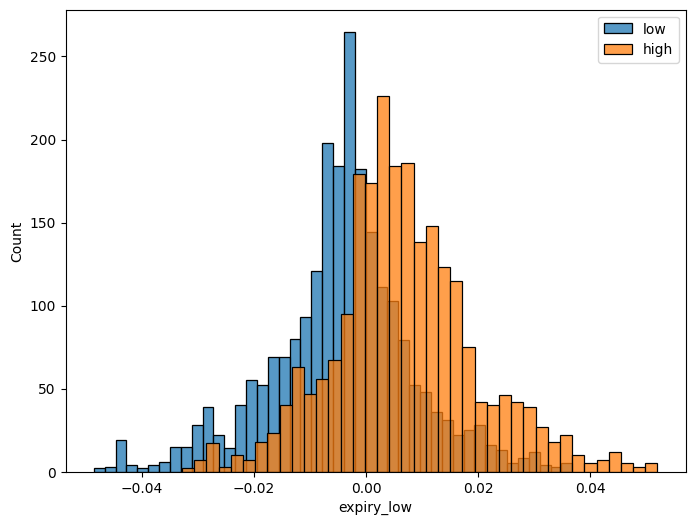

In [80]:
f, ax = plt.subplots(1,1,figsize=(8, 6))
sns.histplot(data=low_df, x="expiry_low", ax=ax, label="low")
sns.histplot(data=high_df, x="expiry_high", ax=ax, label="high")
plt.legend()

#### Fitting against `expiry_[low|high]`

In [40]:
FEATURES = list(low_df.columns)
FEATURES.remove("expiry_low")

split_idx = int(len(low_df) * 0.8) 
train_low_df = low_df.iloc[:split_idx]
train_high_df = high_df.iloc[:split_idx]

valid_low_df = low_df.iloc[split_idx:]
valid_high_df = high_df.iloc[split_idx:]

print(train_low_df.shape, train_high_df.shape, valid_low_df.shape, valid_high_df.shape)

(1860, 43) (1860, 43) (466, 43) (466, 43)


In [64]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform, randint

def fit_randomized_search_model(model, params, X, y): 
    tscv = TimeSeriesSplit(n_splits=5)
    m = RandomizedSearchCV(model, params, random_state=33, 
                           cv=tscv, scoring="neg_root_mean_squared_error")
    m.fit(X, y)
    return m

rfc_params = {
    'n_estimators' : randint(50, 250),
    'max_depth' : randint(10, 30),
    'min_samples_leaf': randint(4, 12)
}
low_rfc = fit_randomized_search_model(RandomForestRegressor(n_jobs=4), rfc_params, 
                                      train_low_df[FEATURES], train_low_df["expiry_low"])
high_rfc = fit_randomized_search_model(RandomForestRegressor(n_jobs=4), rfc_params, 
                                       train_high_df[FEATURES], train_high_df["expiry_high"])

gbt_params = {
    'n_estimators' : randint(50, 250),
    'max_depth' : randint(10, 30),
    'min_samples_leaf': uniform(0.02, 0.2),
    'min_samples_split': uniform(0.01, 0.1),
}
low_gbt = fit_randomized_search_model(GradientBoostingRegressor(), gbt_params, 
                                      train_low_df[FEATURES], train_low_df["expiry_low"])
high_gbt = fit_randomized_search_model(GradientBoostingRegressor(), gbt_params, 
                                       train_high_df[FEATURES], train_high_df["expiry_high"])

In [65]:
display((low_rfc.best_score_, low_gbt.best_score_))
display((high_rfc.best_score_, high_gbt.best_score_))

(-0.01683267707926582, -0.01684258569202405)

(-0.01667241324863905, -0.01655356233943266)

In [67]:
display((low_rfc.best_params_, high_gbt.best_params_))

({'max_depth': 16, 'min_samples_leaf': 10, 'n_estimators': 66},
 {'max_depth': 21,
  'min_samples_leaf': 0.12551021348787222,
  'min_samples_split': 0.043147672954366764,
  'n_estimators': 86})

In [68]:
low_model = RandomForestRegressor(n_jobs=4, **low_rfc.best_params_)
low_model.fit(train_low_df[FEATURES], train_low_df["expiry_low"])
high_model = GradientBoostingRegressor(**high_gbt.best_params_)
high_model.fit(train_high_df[FEATURES], train_high_df["expiry_high"])

GradientBoostingRegressor(max_depth=21, min_samples_leaf=0.12551021348787222,
                          min_samples_split=0.043147672954366764,
                          n_estimators=86)

In [70]:
from joblib import dump
dump(low_model, DATA_DIR / 'models/option_short_strangle_low_model.joblib')
dump(high_model, DATA_DIR / 'models/option_short_strangle_high_model.joblib')

['/mnt/HDD/Data/backtest/models/option_short_strangle_high_model.joblib']